In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import warnings
from scipy.special import comb

In [2]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\VIS_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,24700.085804,0.913045,0.002181,4048.568932
1,24700.082038,0.911843,0.002247,4048.569549
2,24700.078271,0.883065,0.002311,4048.570167
3,24700.074505,0.862602,0.002342,4048.570784
4,24700.070738,0.867600,0.002327,4048.571401
...,...,...,...,...
4057457,9387.232391,1.000976,0.013178,10652.767060
4057458,9387.228625,1.000718,0.013185,10652.771334
4057459,9387.224858,1.001793,0.013186,10652.775608
4057460,9387.221092,1.003057,0.013182,10652.779883


In [3]:
#Lines from the excel
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\lineas_2.0.xlsx", skiprows=6, usecols=[0], names=['lambda'])
raw_lambda

,lambda
0,4056.1809
1,4059.9003
2,4060.8601
3,4063.5882
4,4067.7336
...,...
951,10472.5230
952,10535.1220
953,10558.5430
954,10580.0390


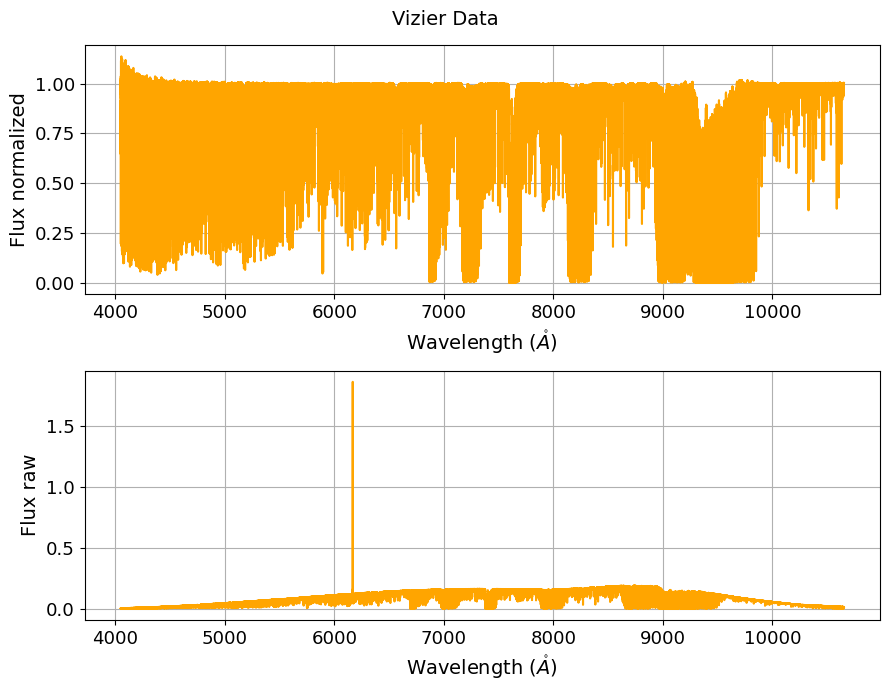

In [4]:
#Plot of raw data
fig1, axis1 = plt.subplots(2,1, figsize = (9, 7),)
ax1 = axis1[0]
ax2 = axis1[1]

fig1.suptitle(r'Vizier Data',fontsize=14)

ax1.plot(raw_data['Wave A'],raw_data['nFlux'],color='orange')
ax1.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax1.set_ylabel('Flux normalized',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.plot(raw_data['Wave A'],raw_data['rFlux'],color='orange')
ax2.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax2.set_ylabel('Flux raw',fontsize=14)
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)

fig1.tight_layout()

### Wavelength classification

In [5]:
#between work like < or > but not the equal, reset the index for the other functions
data_4000_5000 = raw_data[raw_data['Wave A'].between(4000, 5000, inclusive='neither')].reset_index(drop=True)
data_5000_6000 = raw_data[raw_data['Wave A'].between(5000, 6000, inclusive='neither')].reset_index(drop=True)
data_6000_7000 = raw_data[raw_data['Wave A'].between(6000, 7000, inclusive='neither')].reset_index(drop=True)
data_7000_8000 = raw_data[raw_data['Wave A'].between(7000, 8000, inclusive='neither')].reset_index(drop=True)
data_8000_9000 = raw_data[raw_data['Wave A'].between(8000, 9000, inclusive='neither')].reset_index(drop=True)
data_9000_10000 = raw_data[raw_data['Wave A'].between(9000, 10000, inclusive='neither')].reset_index(drop=True)
data_10000_11000 = raw_data[raw_data['Wave A'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)

data_10000_11000

,Wave (cm),nFlux,rFlux,Wave A
0,9999.998584,0.996400,0.054332,10000.001416
1,9999.994818,0.996395,0.054278,10000.005182
2,9999.991051,0.996143,0.054249,10000.008949
3,9999.987285,0.995631,0.054277,10000.012715
4,9999.983518,0.994893,0.054311,10000.016482
...,...,...,...,...
162687,9387.232391,1.000976,0.013178,10652.767060
162688,9387.228625,1.000718,0.013185,10652.771334
162689,9387.224858,1.001793,0.013186,10652.775608
162690,9387.221092,1.003057,0.013182,10652.779883


In [6]:
#Now from lambda
lambda_4000_5000 = raw_lambda[raw_lambda['lambda'].between(4000, 5000, inclusive='neither')].reset_index(drop=True)
lambda_5000_6000 = raw_lambda[raw_lambda['lambda'].between(5000, 6000, inclusive='neither')].reset_index(drop=True)
lambda_6000_7000 = raw_lambda[raw_lambda['lambda'].between(6000, 7000, inclusive='neither')].reset_index(drop=True)
lambda_7000_8000 = raw_lambda[raw_lambda['lambda'].between(7000, 8000, inclusive='neither')].reset_index(drop=True)
lambda_8000_9000 = raw_lambda[raw_lambda['lambda'].between(8000, 9000, inclusive='neither')].reset_index(drop=True)
lambda_9000_10000 = raw_lambda[raw_lambda['lambda'].between(9000, 10000, inclusive='neither')].reset_index(drop=True)
lambda_10000_11000 = raw_lambda[raw_lambda['lambda'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)

lambda_4000_5000

,lambda
0,4056.1809
1,4059.9003
2,4060.8601
3,4063.5882
4,4067.7336
...,...
270,4986.9382
271,4987.6138
272,4990.3419
273,4992.6608


### Find the minimums and the closer line of the Fe I line


In [7]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the rest between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #take all the row

    #Dataframe with the marks for the closer lines of Fe
    closer_lines = pd.concat(closer,axis=0).reset_index(drop=True).drop(['abs'],axis=1)

    return closer_lines

#Data
closer_lines_4000_5000 = find_minimums(data_4000_5000['Wave A'],data_4000_5000['nFlux'],lambda_4000_5000['lambda'])
closer_lines_5000_6000 = find_minimums(data_5000_6000['Wave A'],data_5000_6000['nFlux'],lambda_5000_6000['lambda'])
closer_lines_6000_7000 = find_minimums(data_6000_7000['Wave A'],data_6000_7000['nFlux'],lambda_6000_7000['lambda'])
closer_lines_7000_8000 = find_minimums(data_7000_8000['Wave A'],data_7000_8000['nFlux'],lambda_7000_8000['lambda'])
closer_lines_8000_9000 = find_minimums(data_8000_9000['Wave A'],data_8000_9000['nFlux'],lambda_8000_9000['lambda'])
closer_lines_9000_10000 = find_minimums(data_9000_10000['Wave A'],data_9000_10000['nFlux'],lambda_9000_10000['lambda'])
closer_lines_10000_11000 = find_minimums(data_10000_11000['Wave A'],data_10000_11000['nFlux'],lambda_10000_11000['lambda'])

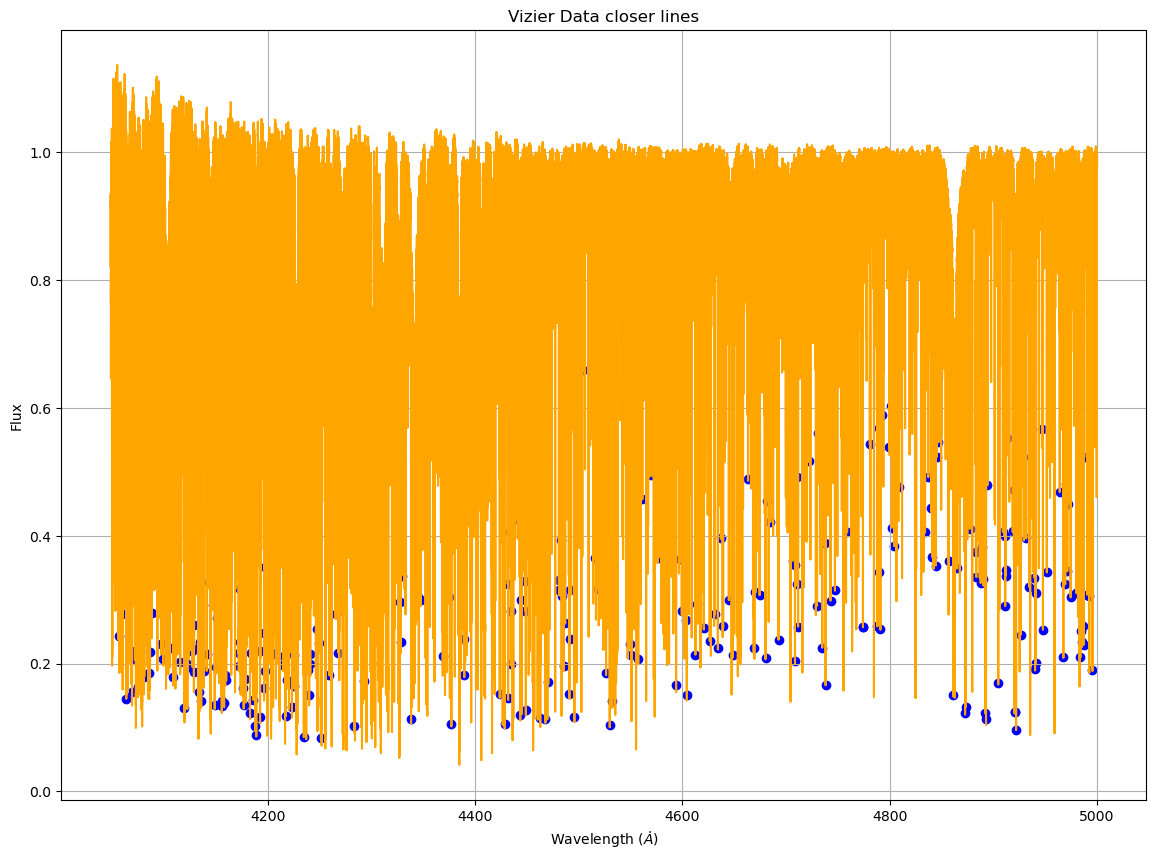

In [8]:
fig3, ax = plt.subplots(1,1,figsize=(14,10))
ax.plot(data_4000_5000['Wave A'],data_4000_5000['nFlux'], color='orange')
ax.scatter(closer_lines_4000_5000['min_wave'],closer_lines_4000_5000['min_flux'], color='blue')
ax.set_title('Vizier Data closer lines')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

In [9]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-0.05, each+0.05, inclusive='neither')])

    return local_points

#Data
local_points_4000_5000 = width_minimums(closer_lines_4000_5000,data_4000_5000)
local_points_5000_6000 = width_minimums(closer_lines_5000_6000,data_5000_6000)
local_points_6000_7000 = width_minimums(closer_lines_6000_7000,data_6000_7000)
local_points_7000_8000 = width_minimums(closer_lines_7000_8000,data_7000_8000)
local_points_8000_9000 = width_minimums(closer_lines_8000_9000,data_8000_9000)
local_points_9000_10000 = width_minimums(closer_lines_9000_10000,data_9000_10000)
local_points_10000_11000 = width_minimums(closer_lines_10000_11000,data_10000_11000)

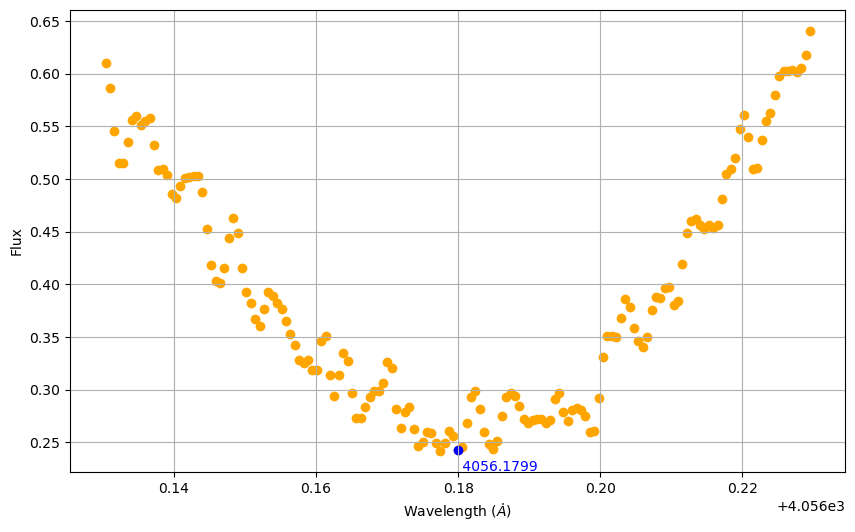

In [10]:
#For the example we take the first line
fig4, ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(local_points_4000_5000[0]['Wave A'],local_points_4000_5000[0]['nFlux'], color='orange')
ax.scatter(closer_lines_4000_5000['min_wave'][0],closer_lines_4000_5000['min_flux'][0], color='blue')
ax.text(closer_lines_4000_5000['min_wave'][0],closer_lines_4000_5000['min_flux'][0] -0.02, ' {}'.format( round(closer_lines_4000_5000['min_wave'][0],4)), color='blue')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

### Derivates and fit

El problema era que el fit se estaba imponiendo sobre los datos aunque estaba mal condicionado. Por ello, decidí escalar los datos.

Cuando los valores de x son muy grandes en los fit, términos como $x^4$ generan números extremadamente grandes lo que hace que se condicione de mala forma el ajuste. Además veía que los términos de alto grado dominan numéricamente sobre los de bajo grado.

Como el escalado es una transformación lineal reversible el polinomio ajustado es equivalente al que se usa sin escalar, solo se cambia la representación numérica.

In [11]:
def Fit_derivates(local_points,lamda_list):
    values = []
    Flux_fit = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of lines 

        #Internal rise, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #take the conditional for the division

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Evaluate the fit with the coeficients and the data scaled, this is the fit perse
        wave_new_scaled = (np.array(data_wave) - wave_mean)/wave_std if wave_std != 0 else data_wave #x data for the fit,scaled too
        flux_fit = np.polyval(param[::-1], wave_new_scaled) #This function is who evaluated the new scaled data in the polinomial fit

        #Re-scalated the parameters, vandermont matrix reversed
        param_original = np.zeros(5)

        for k in range(5):
            binom_coeffs = comb(k, np.arange(k + 1))  #Binomial coeficients for just use one cycle
            contributions = param[4 - k] * binom_coeffs * ((-wave_mean) ** (k - np.arange(k + 1))) / (wave_std ** k)
            param_original[4 - k : 5] += contributions[::-1]  #the index

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param_original) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] ) #check with the second derivate, just positive values for minimums
        value_roots = pol(valid_roots) #evaluate in the polinomium for the global minimum
        minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #take the values

        #For the lambda convert the minimal root in wave with the scale of the mean, we dont scale the flux data
        lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,3), minimal_root[1]]

        #Evaluate the second and third derivate in the lambda observed
        #Formula for the third derivate
        def Third_Derivate(second, third):
            return -((third)/(3*(second**2)))

        d2 = poly.polyval(lamda_obs[0],d2_param)
        d3 = Third_Derivate(d2, poly.polyval(lamda_obs[0],d3_param))

        #Calculate the velocity
        C = 299792458
        velocity = round((((lamda_obs[0]/lamda_list[i]) - 1) * C) - 633) #Formula for relativistic aproximation

    
        values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2,d3]])) #natural lambda, observed lambda, flux, velocity, second derivate, third derivate

        Flux_fit.append(flux_fit)

    Values =  pd.concat(values,axis=0).reset_index(drop=True)
    Values.columns = ["Lambda natural", "Lambda observed", "Flux",'Velocity','2nd Derivate','3rd Derivate']

    return Values, Flux_fit

Values_4000_5000, Flux_fit_4000_5000 = Fit_derivates(local_points_4000_5000,lambda_4000_5000['lambda'])
Values_5000_6000, Flux_fit_5000_6000 = Fit_derivates(local_points_5000_6000,lambda_5000_6000['lambda'])
Values_6000_7000, Flux_fit_6000_7000 = Fit_derivates(local_points_6000_7000,lambda_6000_7000['lambda'])
Values_7000_8000, Flux_fit_7000_8000 = Fit_derivates(local_points_7000_8000,lambda_7000_8000['lambda'])
Values_8000_9000, Flux_fit_8000_9000 = Fit_derivates(local_points_8000_9000,lambda_8000_9000['lambda'])
Values_9000_10000, Flux_fit_9000_10000 = Fit_derivates(local_points_9000_10000,lambda_9000_10000['lambda'])
Values_10000_11000, Flux_fit_10000_11000 = Fit_derivates(local_points_10000_11000,lambda_10000_11000['lambda'])

In [ ]:
#Make a Big dataframe for the plot
Values = pd.concat([Values_4000_5000,Values_5000_6000,Values_6000_7000,Values_7000_8000,Values_8000_9000,Values_9000_10000,Values_10000_11000],axis=0)
#separate for color range, make a list
values_colors = [ Values[Values['Lambda observed'].between(3800, 4270, inclusive='neither')],
                 Values[Values['Lambda observed'].between(4270, 4760, inclusive='neither')],
                 Values[Values['Lambda observed'].between(4760, 4970, inclusive='neither')],
                 Values[Values['Lambda observed'].between(4970, 5700, inclusive='neither')],
                 Values[Values['Lambda observed'].between(5700, 5810, inclusive='neither')],
                 Values[Values['Lambda observed'].between(5810, 6180, inclusive='neither')],
                 Values[Values['Lambda observed'].between(6180, 7800, inclusive='neither')],
                 Values[Values['Lambda observed'].between(7800, 11000, inclusive='neither')]
]

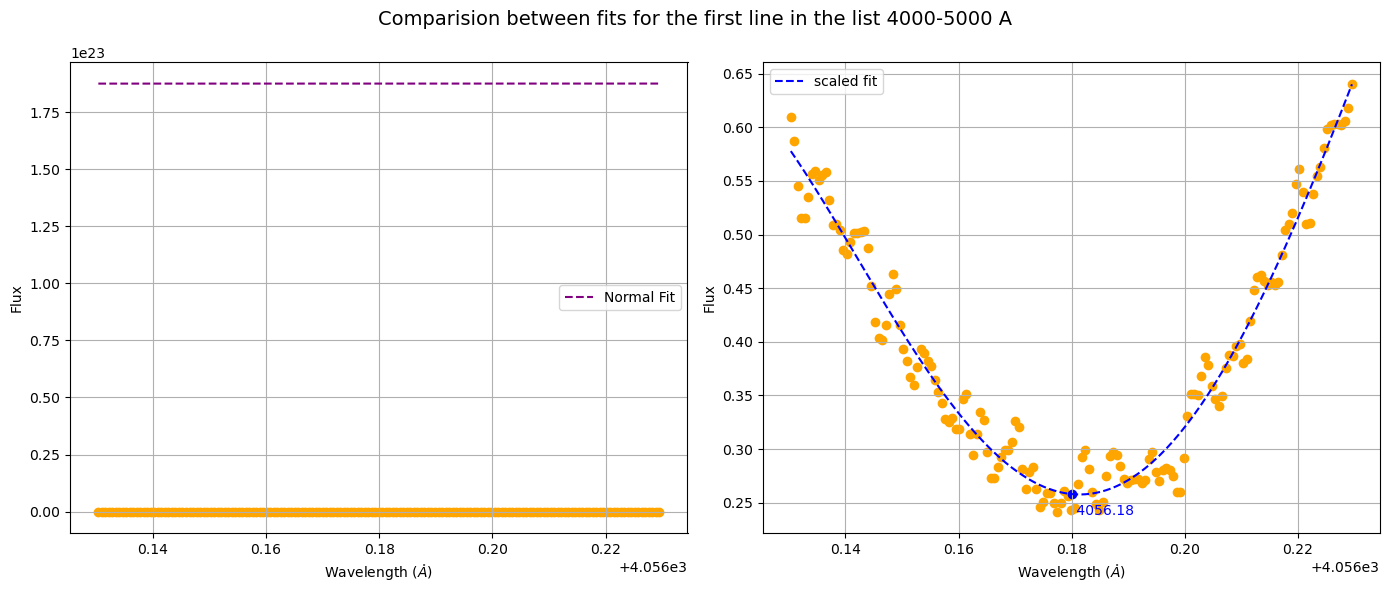

In [14]:
#For the example we take the first line
#Show the other fit
with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.polynomial.polyutils.RankWarning)
        coefs = poly.polyfit(local_points_4000_5000[0]['Wave A'], local_points_4000_5000[0]['nFlux'], 4)

pol_other = np.poly1d(coefs)
other_fit = pol_other(local_points_4000_5000[0]['Wave A'])

#graphic for the first line
fig4, axis4 = plt.subplots(1,2, figsize = (14, 6))
ax1 = axis4[0]
ax2 = axis4[1]

fig4.suptitle(r'Comparision between fits for the first line in the list 4000-5000 A',fontsize=14)

ax1.scatter(local_points_4000_5000[0]['Wave A'],local_points_4000_5000[0]['nFlux'], color='orange')
ax1.plot(local_points_4000_5000[0]['Wave A'],other_fit, '--',color='purple',label = 'Normal Fit')
ax1.set_xlabel(r'Wavelength $(\mathring{A})$')
ax1.set_ylabel('Flux')
ax1.grid()
ax1.legend()

ax2.scatter(local_points_4000_5000[0]['Wave A'],local_points_4000_5000[0]['nFlux'], color='orange')
ax2.plot(local_points_4000_5000[0]['Wave A'],Flux_fit_4000_5000[0], '--',color='blue',label='scaled fit')
ax2.scatter(Values_4000_5000['Lambda observed'][0],Values_4000_5000['Flux'][0], color='blue')
ax2.text(Values_4000_5000['Lambda observed'][0],Values_4000_5000['Flux'][0] -0.02, ' {}'.format( round(Values_4000_5000['Lambda observed'][0],4)), color='blue')
ax2.set_xlabel(r'Wavelength $(\mathring{A})$')
ax2.set_ylabel('Flux')
ax2.grid()
ax2.legend()

fig4.tight_layout()

In [ ]:
#Convert to excel
# Values_4000_5000.to_excel('valores_4000_5000.xlsx', index=False)

### Graphics for the first set 4000-5000 A

In [18]:
#colors for the plot
colors = ['violet','blue','cyan','green','yellow','orange','red','brown']

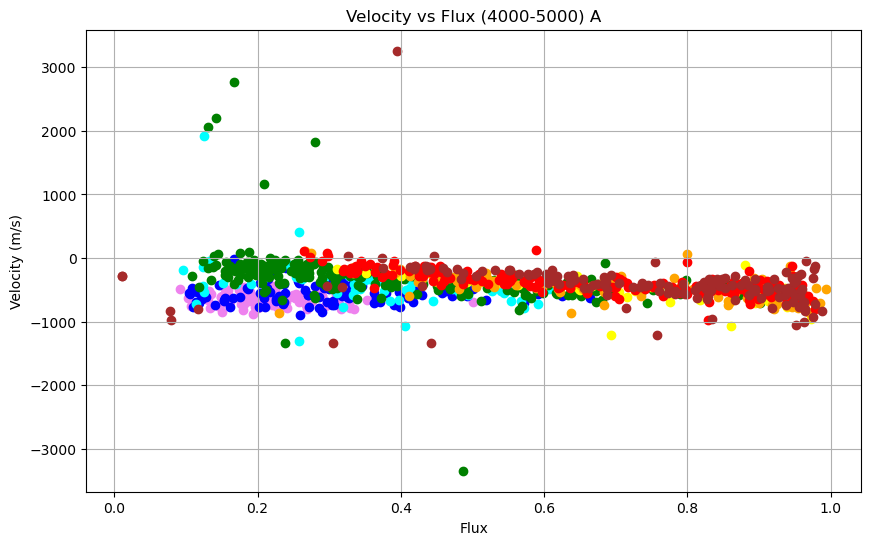

In [19]:
#Velocity vs Flux 
fig5, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['Velocity'], c=colors[i])

ax.set_title('Velocity vs Flux (4000-5000) A')
ax.set_xlabel(r'Flux')
ax.set_ylabel('Velocity (m/s)')
ax.grid()

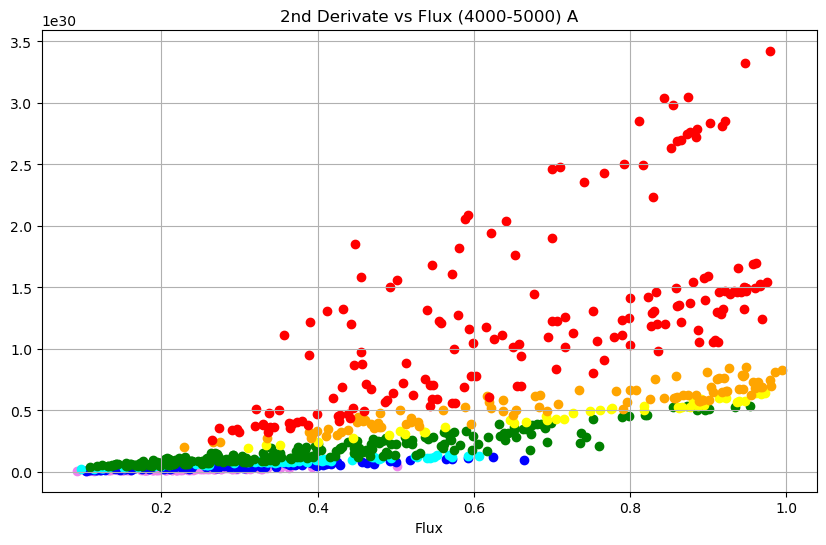

In [25]:
#2nd Derivate vs Flux
fig6, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)-1):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['2nd Derivate'], color=colors[i])

ax.set_title('2nd Derivate vs Flux (4000-5000) A')
ax.set_xlabel(r'Flux')
ax.grid()

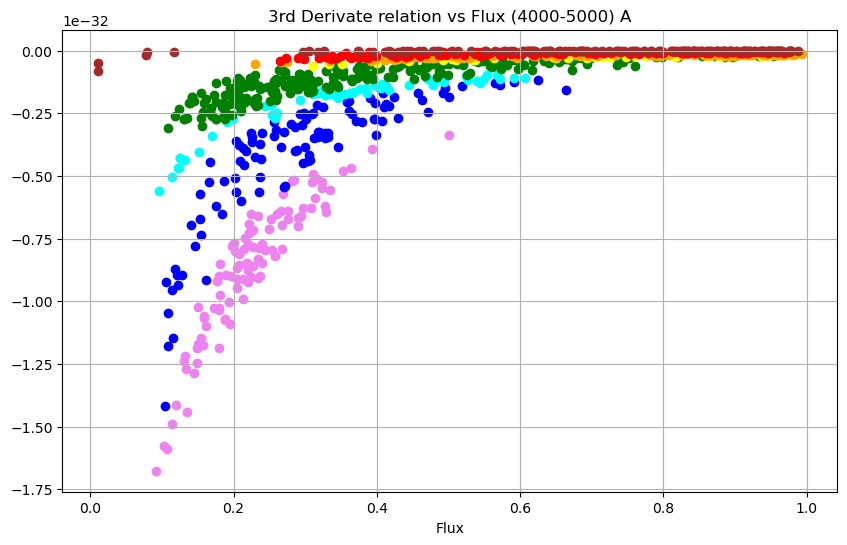

In [21]:
#3rd Derivate vs Flux
fig6, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['3rd Derivate'], color=colors[i])

ax.set_title('3rd Derivate relation vs Flux (4000-5000) A')
ax.set_xlabel(r'Flux')
ax.grid()